In [1]:
import pandas as pd
import numpy as np
import json
import sys

In [2]:
from src import *

business_df = pd.read_json('../database/yelp_academic_dataset_business.json', lines=True)
review_df = pd.read_json('../database/yelp_academic_dataset_review.json', lines=True)
pred_df = pd.read_json('../database/review_predictions.json', lines=True)

In [3]:
# Set the lambda value
_lambda = 0.7  # Can be adjusted as needed

review_df = review_df.merge(pred_df, on='review_id', how='left')
review_df['stars'] = (_lambda * review_df['predicted_stars'] + (1 - _lambda) * review_df['true_stars']).round(2)
review_df.drop(['predicted_stars', 'true_stars'], axis=1, inplace=True)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
main_color = ['#00754B', '#C8FCEA', '#6A9A8B']

# Exploratory Data Analysis

## View the number of unique business categories in each city

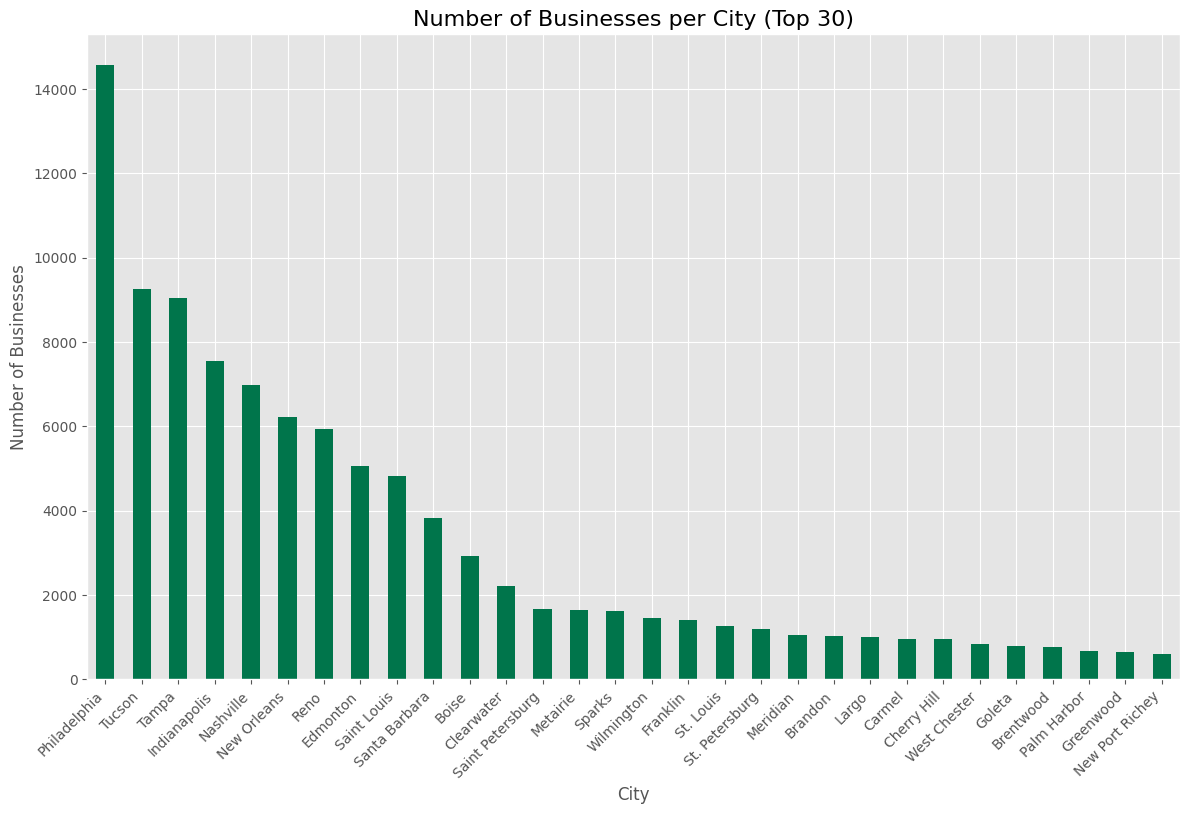

In [5]:
# Group by city and count the number of businesses
yelp_business_groups = business_df.groupby('city').count()
yelp_business_city = yelp_business_groups['name']
yelp_business_city_sorted = yelp_business_city.sort_values(ascending=False)

# Plot a bar chart for the top 30 cities
ax = yelp_business_city_sorted[:30].plot(
    kind='bar', figsize=(12, 8), color=main_color[0])
ax.set_xticklabels(
    yelp_business_city_sorted[:30].index, rotation=45, ha='right')

ax.set_xlabel('City')
ax.set_ylabel('Number of Businesses')
plt.tight_layout()
plt.savefig('../static/experiments/01_Number_of_Businesses_per_City.png', dpi=600)
ax.set_title('Number of Businesses per City (Top 30)', fontsize=16)
plt.show()

## View the different types of business categories and their respective counts

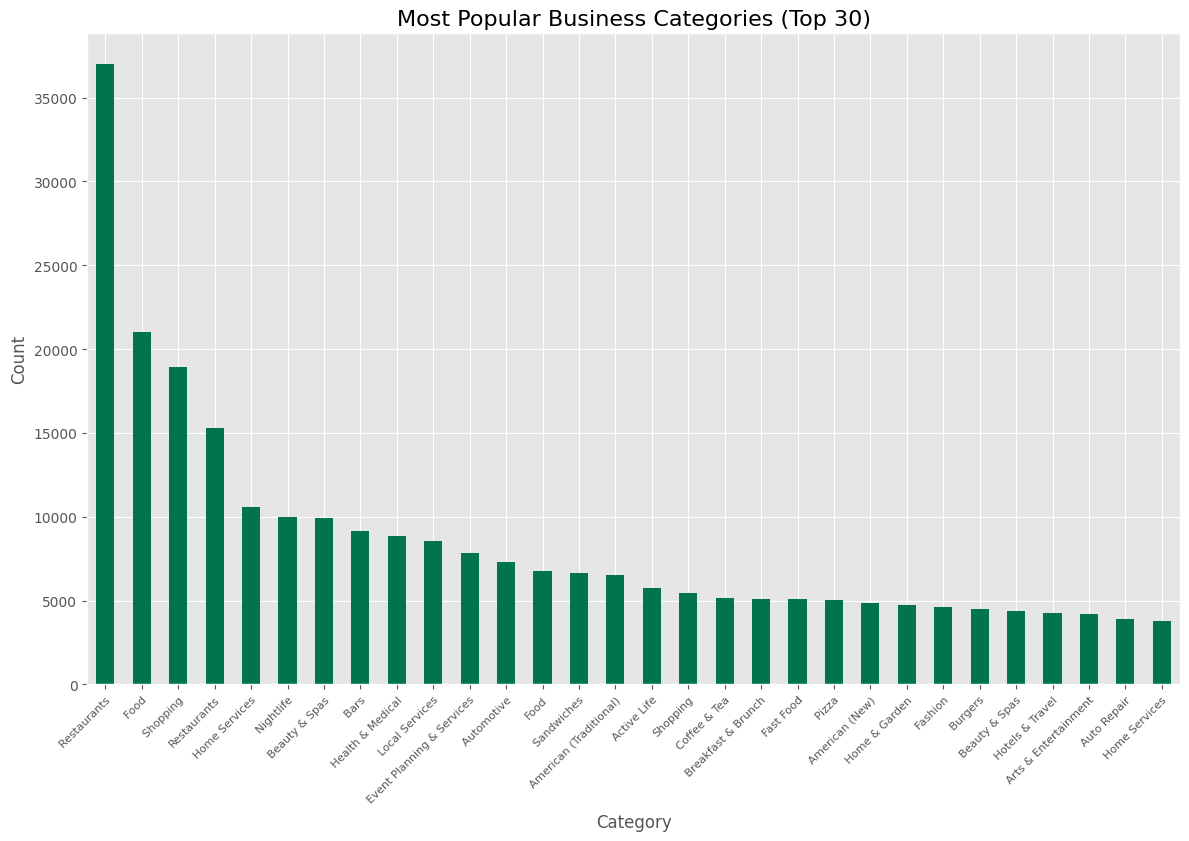

In [6]:
# First, count the occurrences of each business category
categories_dict = {}
for _ in business_df.categories:
    cat = str(_).split(',')
    for j in cat:
        if j not in categories_dict:
            categories_dict[j] = 1
        else:
            categories_dict[j] += 1

categories_series = pd.Series(categories_dict)
categories_series.sort_values(ascending=False, inplace=True)

# Plot a bar chart of the top 30 most popular business categories
ax = categories_series[:30].plot(
    kind='bar', color=main_color[0], figsize=(12, 8))
ax.set_xticklabels(
    categories_series[:30].index,
    rotation=45, ha='right', wrap=True,
    fontsize=8)

ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('../static/experiments/02_Most_Popular_Business_Categories.png', dpi=600)
ax.set_title('Most Popular Business Categories (Top 30)', fontsize=16)
plt.show()

## Ordered pairs of business categories and cities with their counts

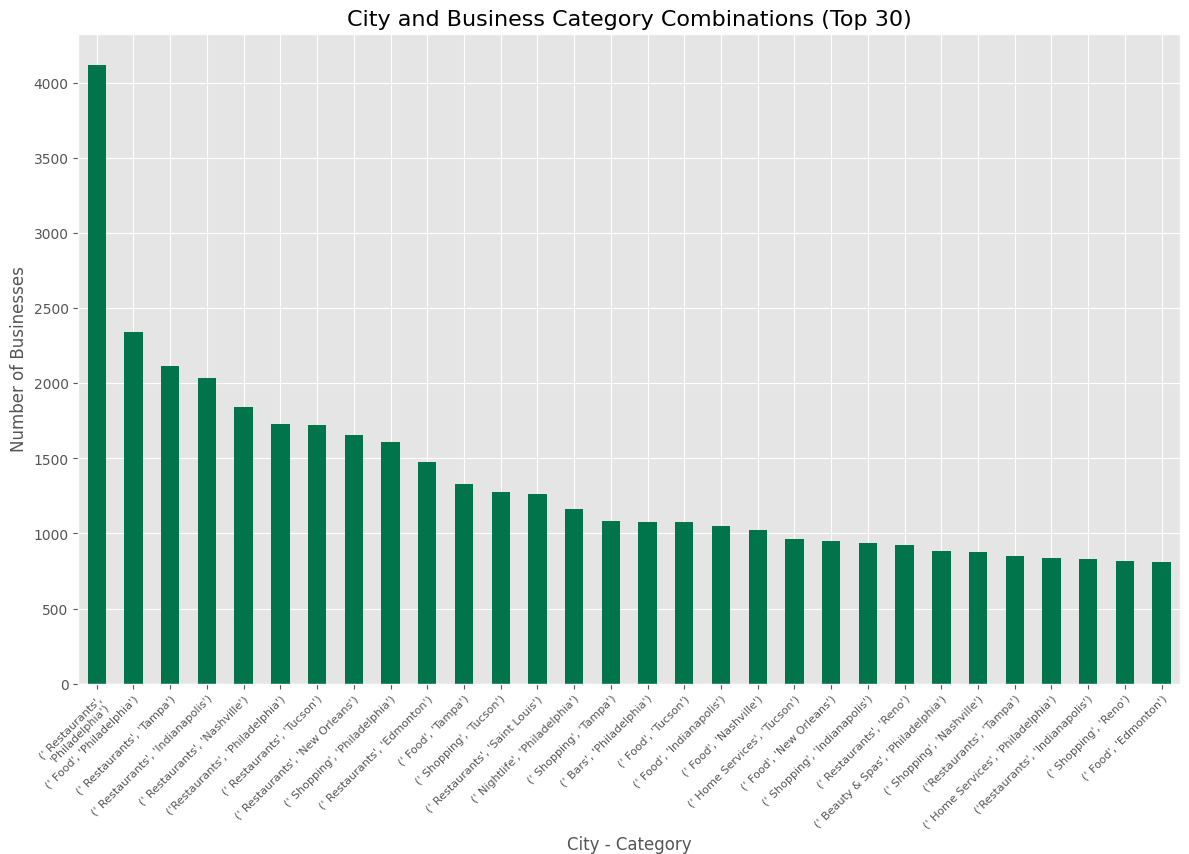

In [7]:
# Create the business_city dictionary to store the number of businesses per city-category pair
business_city = {}
n = len(business_df)

for _ in range(n):
    k1 = str(business_df.categories.iloc[_]).split(',')
    k2 = business_df.city.iloc[_]
    for j in k1:
        k = (j, k2)
        if k not in business_city:
            business_city[k] = 1
        else:
            business_city[k] += 1

# Convert the dictionary to a Series and sort it
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending=False, inplace=True)

# Plot the top 30 city-category combinations
fig, ax = plt.subplots(figsize=(12, 8))
business_city_series[:30].plot(kind='bar', color=main_color[0], ax=ax)

ax.set_xticklabels(
    business_city_series[:30].index,
    rotation=45, ha='right',
    wrap=True, fontsize=8)

ax.set_xlabel('City - Category')
ax.set_ylabel('Number of Businesses')
plt.tight_layout()
plt.savefig('../static/experiments/03_City_Category_Combination_Counts.png', dpi=600)
ax.set_title('City and Business Category Combinations (Top 30)', fontsize=16)
plt.show()

It is evident that the majority of businesses listed on Yelp are restaurants, shopping venues, and entertainment centers.For this dataset , the cities with the highest number of businesses are `Philadelphia`, `Tampa`, and `Indianapolis`.

In [8]:
# Filter out all businesses that belong to the "Restaurant" category
restaurants = business_df[business_df['categories'].str.contains('Restaurant', case=False) == True]

# Filter out reviews whose business_id exists in the list of restaurant business IDs
restaurant_reviews = review_df[review_df.business_id.isin(
    restaurants['business_id']) == True]

print(f"Dimensions of restaurant_reviews dataframe: {restaurant_reviews.shape}")

Dimensions of restaurant_reviews dataframe: (4724684, 9)


# Clean review data

## Remove unnecessary columns

- `text`: review text,
- `useful`: number of users who found the review useful,
- `date`: review date

The remaining columns are `user_id`, `business_id`, and `stars`(processed and summed).

In [9]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [10]:
yelp_cleaned = review_df.drop(['text',
                          'useful',
                          'cool',
                          'date',
                          'funny'], axis=1)
yelp_cleaned.head()

,review_id,user_id,business_id,stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.7
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0


## Merge data
Merge business data (`yelp_academic_dataset_business.csv`) with review data (`yelp_academic_dataset_review.csv`) using 'business_id' as the primary key. Information like 'city' and 'categories' from the business file will be added to the corresponding reviews.


In [11]:
yelp_full = yelp_cleaned.merge(
    business_df[['city',
                   'categories',
                   'business_id']], how='inner', on='business_id')

df = yelp_full.dropna()

Retrieve the top 30 business categories and cities with the highest number of reviews

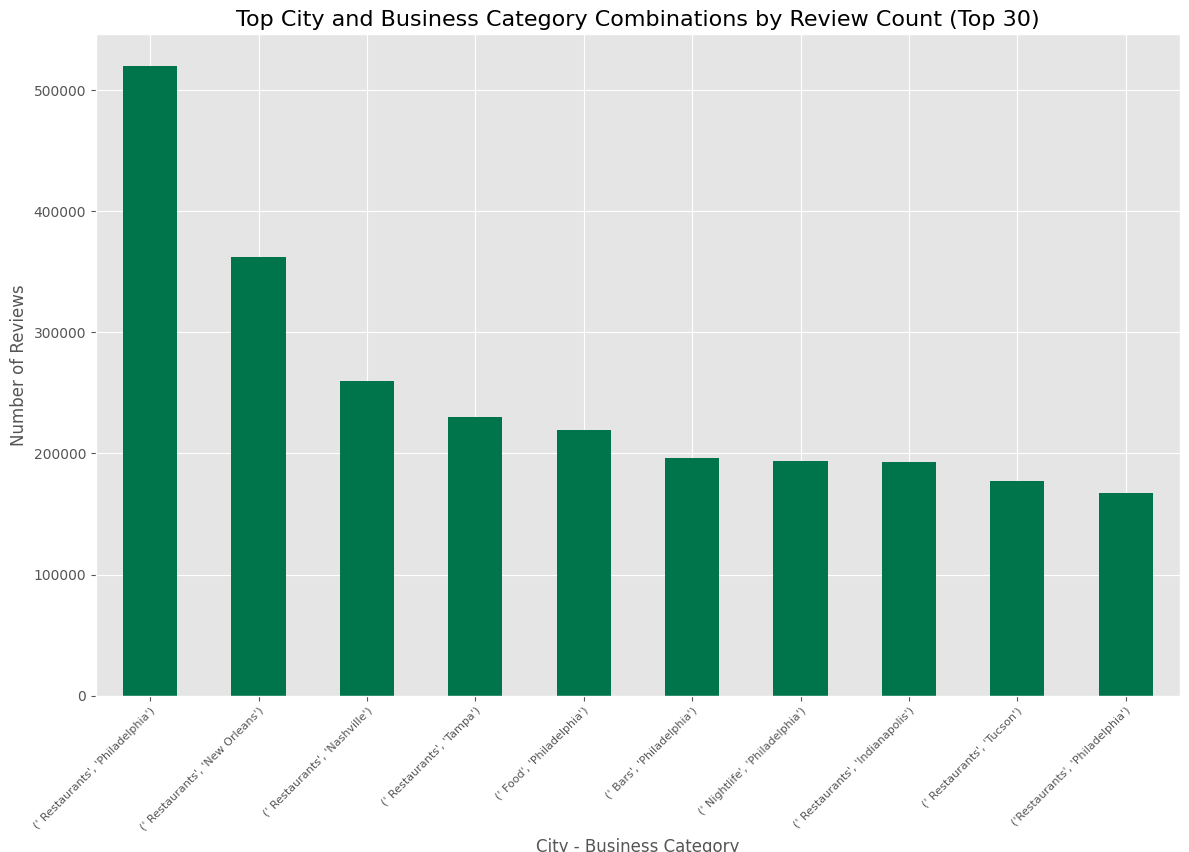

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

review_business_city = get_top_m_num_reviews_for_city_and_business(df, 10)

review_business_city[:30].plot(kind='bar', color=main_color[0], ax=ax)

ax.set_xticklabels(
    review_business_city[:30].index,
    rotation=45, ha='right',
    wrap=True, fontsize=8
)
ax.set_xlabel('City - Business Category')
ax.set_ylabel('Number of Reviews')
plt.tight_layout()
plt.savefig('../static/experiments/04_Top_City_Business_Review_Counts.png', dpi=600)
ax.set_title('Top City and Business Category Combinations by Review Count (Top 30)', fontsize=16)
plt.show()

In [ ]:
df.to_csv('../database/Yelp_final.csv', index=False)